## Installing Pints

### Importing required libraries & pints

In [1]:
!pip install pints

In [2]:
import numpy as np
import pandas as pd
import h5py
import pints
import pints.toy
import pints.plot
import matplotlib.pyplot as plt


### Testing to see if the model works

suggested parameters  [   1 1000    5    2]
suggested times length  400
the initial values  [0 0 0 2 1 3]
number of outputs 3
number of parameters 4
values shape  (400, 3)
Parameters:
[   1 1000    5    2]


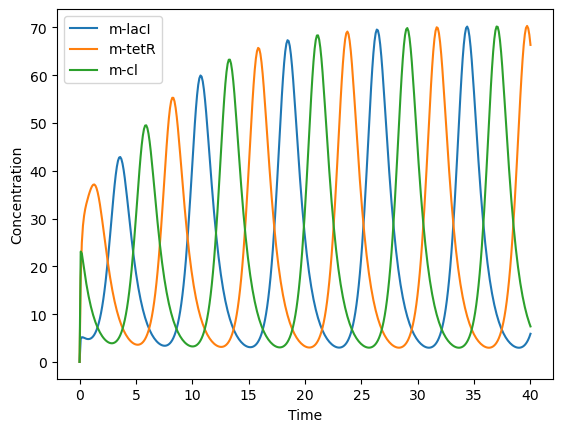

In [3]:
import pints
import pints.toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Create a model
model = pints.toy.RepressilatorModel()

# Run a simulation
parameters = model.suggested_parameters()
print(f"suggested parameters ",model.suggested_parameters())
print(f"suggested times length ",len(model.suggested_times()))
print(f"the initial values ",model._y0)
print(f"number of outputs",model.n_outputs())
print(f"number of parameters",model.n_parameters())
times = model.suggested_times()
values = model.simulate(parameters, times)
print(f"values shape ",values.shape)

print('Parameters:')
print(parameters)

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.plot(times, values)
plt.legend(['m-lacI', 'm-tetR', 'm-cl'])
plt.show()

## Mount to (local or google drive) and create data directory

### Google drive

In [4]:
## Google Drive
#from google.colab import drive
#drive.mount('/content/gdrive')

In [21]:
#%cd /content/gdrive/MyDrive/
#%mkdir -p SyntheticData/Repressilator
#%cd SyntheticData/Repressilator

### Local Directory

In [22]:
import os
os.makedirs("SyntheticData/Repressilator", exist_ok=True)
os.chdir("SyntheticData/Repressilator")

## Generating the Data

In [23]:
# times [0,40] into 1025 discrete value
times = np.linspace(0, 40, 1025)

# A function that takes a parameter set and times and returns the simulated values
def simulator(parameters, times):
    # randomly sample the y0 values between 0 and 100
    y = np.random.uniform(0, 100, 6)
    model = pints.toy.RepressilatorModel(y0=y)
    return model.simulate(parameters, times)


In [24]:
# Define the parameter ranges
alpha_0_range = (0, 5)
alpha_range = (100, 5000)
beta_range = (0, 10)
n_range = (0, 10)

# Set the number of combinations
num_combinations = 300

# Use numpy to generate the combinations with uniform distribution
alpha_0_values = np.random.uniform(alpha_0_range[0], alpha_0_range[1], num_combinations)
alpha_values = np.random.uniform(alpha_range[0], alpha_range[1], num_combinations)
beta_values = np.random.uniform(beta_range[0], beta_range[1], num_combinations)
n_values = np.random.uniform(n_range[0], n_range[1], num_combinations)

# Combine the values into a DataFrame
combinations = pd.DataFrame({
    'alpha_0': alpha_0_values,
    'alpha': alpha_values,
    'beta': beta_values,
    'n': n_values
})

# Ensure uniqueness (though with uniform random generation, collisions are highly unlikely)
combinations = combinations.drop_duplicates()

# If there are not enough unique combinations, regenerate until we have enough
while len(combinations) < num_combinations:
    additional_combinations = pd.DataFrame({
        'alpha_0': np.random.uniform(alpha_0_range[0], alpha_0_range[1], num_combinations - len(combinations)),
        'alpha': np.random.uniform(alpha_range[0], alpha_range[1], num_combinations - len(combinations)),
        'beta': np.random.uniform(beta_range[0], beta_range[1], num_combinations - len(combinations)),
        'n': np.random.uniform(n_range[0], n_range[1], num_combinations - len(combinations))
    })
    combinations = pd.concat([combinations, additional_combinations]).drop_duplicates()

# Ensure we have exactly the desired number of unique combinations
combinations = combinations.head(num_combinations)

print(combinations)

      alpha_0        alpha      beta         n
0    3.097311  1552.750017  2.822740  2.131008
1    3.852794  4838.632580  7.352901  7.559224
2    0.829911  2044.109786  7.968506  2.131488
3    4.478400  2825.856398  7.448662  3.767527
4    4.675024  2791.301900  2.180162  1.400353
..        ...          ...       ...       ...
295  1.303105  3476.080866  5.675132  2.041727
296  3.746058  3238.587467  5.655418  1.882261
297  4.092831  1624.107792  8.550142  3.082374
298  0.881864  3514.675586  5.509319  0.486535
299  2.817298  4086.650995  1.840082  5.766707

[300 rows x 4 columns]


### Generating the Training Data

In [25]:
with h5py.File('Repressilator_training.hdf5', 'w') as f:
    for i, row in combinations.head(256).iterrows():
        parameters = [row['alpha_0'], row['alpha'], row['beta'], row['n']]
        values = simulator(parameters, times)
        f.create_dataset(str(i), data=values)

### Generating Validation Data

In [26]:
with h5py.File('Repressilator_valid.hdf5', 'w') as f:
    for i, row in combinations.tail(32).iterrows():
        parameters = [row['alpha_0'], row['alpha'], row['beta'], row['n']]
        values = simulator(parameters, times)
        f.create_dataset(str(i), data=values)